In [1]:
# Modelo VECM

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VECM
import seaborn as sns

In [10]:
data1 = pd.read_csv('data1.csv', delimiter=',', index_col=0 ,parse_dates=True, decimal='.')
data1.columns

Index(['zl_rexm', 'diesel', 'hipotecarios', 'consumo', 'itm', 'zl_mtm',
       'entrada', 'pollo', 'licor', 'pconst_interior', 'f_electricidad',
       'deuda', 'fob', 'zl_impm', 'acp_pm', 'gastotur', 'ibm', 'iim', 'banano',
       'gasolina', 'itmbs', 'apuestas', 'depósitos', 'préstamos', 'comercio',
       'construcción', 'itdm', 'intm', 'activan', 'pasivan', 'dp_pib',
       'pib_corr', 'ingresos_ind', 'ingresos_cmayor', 'ingresos_cmenor',
       'ingresos_hot', 'ingresos_serv', 'ingresos_tot', 'rem_ind',
       'rem_cmayor', 'rem_cmenor', 'rem_hot', 'rem_serv', 'rem_tot', 'ied',
       'ied_empresas', 'ied_bancos', 'imae', 'imae_s', 'bvpsi', 'acp_tbm',
       'acp_tnm', 'mcp', 'visitas', 'vacuno', 'porcino', 'cerveza', 'pconst',
       'pconst_cdad', 'concreto', 'cemento', 'autos', 'g_electricidad',
       'primas', 'activar', 'pasivar', 'pib_cons', 'pib_const_d',
       'pib_const_e', 'pib_const_f', 'pib_const_g', 'pib_const_i',
       'pib_const_j', 'pib_const_m', 'pib_const_a', 

In [11]:
from sklearn.model_selection import train_test_split
# Método de la exclusión
X_train, X_test, y_train, y_test = train_test_split(data1, 
                                                    data1.activar,
                                                    random_state=0)

In [12]:
# Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
select = RFE(RandomForestRegressor(random_state=42), 
             n_features_to_select=10)
select.fit(X_train,y_train)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=10)

([], [])

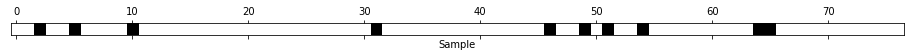

In [13]:
import matplotlib.pyplot as plt
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
plt.xlabel("Sample")
plt.yticks(())

In [14]:
d = { 'variable':data1.columns,'decision':select.support_}
select_RFE = pd.DataFrame(data =d)
select_RFE.head()
seleccionadas = select_RFE[select_RFE['decision']==True]
seleccionadas

,variable,decision
2,hipotecarios,True
5,zl_mtm,True
10,f_electricidad,True
31,pib_corr,True
46,ied_bancos,True
49,bvpsi,True
51,acp_tnm,True
54,vacuno,True
64,activar,True
65,pasivar,True


In [27]:
seleccionadas = ['hipotecarios','zl_mtm','f_electricidad','pib_corr','ied_bancos','bvpsi','acp_tnm',
                 'vacuno','activar','pasivar']
data2 = data1[seleccionadas]
primera_columna = data2.pop('activar') 
data2.insert(0, 'activar', primera_columna)
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2014-03-01 to 2021-09-01
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   activar         87 non-null     float64
 1   hipotecarios    87 non-null     float64
 2   zl_mtm          87 non-null     float64
 3   f_electricidad  87 non-null     float64
 4   pib_corr        87 non-null     float64
 5   ied_bancos      87 non-null     float64
 6   bvpsi           87 non-null     float64
 7   acp_tnm         87 non-null     float64
 8   vacuno          87 non-null     float64
 9   pasivar         87 non-null     float64
dtypes: float64(10)
memory usage: 7.5 KB


In [11]:
# VECM

In [16]:
def modelo (data, y, frecuencia, lags):
    model = VECM(data, deterministic="ci", seasons=frecuencia, k_ar_diff=lags, coint_rank=1) 
    vecm_res = model.fit()
    granger_results = vecm_res.test_granger_causality(caused=y, signif=0.05)
    inst_caus = vecm_res.test_inst_causality(causing=y)
    norm_test = vecm_res.test_normality()
    norm_test.summary()
    white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
    white_test.summary()
    print(granger_results.h0,"/",granger_results.conclusion_str)
    print(inst_caus.h0,"/",inst_caus.conclusion_str)
    print(norm_test.h0,"/",norm_test.conclusion_str)
    print(white_test.h0,"/",white_test.conclusion_str)
    print(vecm_res.summary())

In [28]:
modelo(data=data2, y='activar', frecuencia=12, lags=3)

H_0: ['hipotecarios', 'zl_mtm', 'f_electricidad', 'pib_corr', 'ied_bancos', 'bvpsi', 'acp_tnm', 'vacuno', 'pasivar'] do not Granger-cause activar / Conclusion: reject H_0
H_0: activar does not instantaneously cause [hipotecarios, zl_mtm, f_electricidad, pib_corr, ied_bancos, bvpsi, acp_tnm, vacuno, pasivar] / Conclusion: reject H_0
H_0: data generated by normally-distributed process / Conclusion: fail to reject H_0
H_0: residual autocorrelation up to lag 12 is zero / Conclusion: reject H_0
Det. terms outside the coint. relation & lagged endog. parameters for equation activar
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
season1              -0.0070      0.005     -1.435      0.151      -0.017       0.003
season2              -0.0009      0.005     -0.192      0.848      -0.011       0.009
season3              -0.0053      0.005     -1.120      0.263      -0.015 

C:\Users\vblanco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [29]:
correlacion = data2.corr()
correlacion.style.background_gradient(cmap='coolwarm')
#data_mora.corr()['gasolina']

,activar,hipotecarios,zl_mtm,f_electricidad,pib_corr,ied_bancos,bvpsi,acp_tnm,vacuno,pasivar
activar,1.000000,-0.082333,-0.067681,0.047953,-0.139503,-0.108381,-0.027735,-0.012047,-0.046837,0.526057
hipotecarios,-0.082333,1.000000,-0.575500,-0.004144,-0.113250,0.025492,-0.041777,-0.090644,-0.008775,-0.126392
zl_mtm,-0.067681,-0.575500,1.000000,0.311268,0.392399,-0.082068,0.062012,0.281746,0.211934,-0.075593
f_electricidad,0.047953,-0.004144,0.311268,1.000000,0.115270,-0.034033,-0.139386,0.340747,0.220868,0.024639
pib_corr,-0.139503,-0.113250,0.392399,0.115270,1.000000,-0.237987,-0.088067,0.368691,0.460142,-0.121703
ied_bancos,-0.108381,0.025492,-0.082068,-0.034033,-0.237987,1.000000,0.134056,-0.157433,0.039977,-0.112674
bvpsi,-0.027735,-0.041777,0.062012,-0.139386,-0.088067,0.134056,1.000000,-0.150640,-0.088227,-0.063496
acp_tnm,-0.012047,-0.090644,0.281746,0.340747,0.368691,-0.157433,-0.150640,1.000000,0.454740,0.031550
vacuno,-0.046837,-0.008775,0.211934,0.220868,0.460142,0.039977,-0.088227,0.454740,1.000000,-0.133878
pasivar,0.526057,-0.126392,-0.075593,0.024639,-0.121703,-0.112674,-0.063496,0.031550,-0.133878,1.000000


In [30]:
data2 = data1[seleccionadas]
data2 = data2.drop('pasivar', axis=1)
primera_columna = data2.pop('activar') 
data2.insert(0, 'activar', primera_columna)
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2014-03-01 to 2021-09-01
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   activar         87 non-null     float64
 1   hipotecarios    87 non-null     float64
 2   zl_mtm          87 non-null     float64
 3   f_electricidad  87 non-null     float64
 4   pib_corr        87 non-null     float64
 5   ied_bancos      87 non-null     float64
 6   bvpsi           87 non-null     float64
 7   acp_tnm         87 non-null     float64
 8   vacuno          87 non-null     float64
dtypes: float64(9)
memory usage: 6.8 KB


In [31]:
modelo(data=data2, y='activar', frecuencia=12, lags=5) 

H_0: ['hipotecarios', 'zl_mtm', 'f_electricidad', 'pib_corr', 'ied_bancos', 'bvpsi', 'acp_tnm', 'vacuno'] do not Granger-cause activar / Conclusion: reject H_0
H_0: activar does not instantaneously cause [hipotecarios, zl_mtm, f_electricidad, pib_corr, ied_bancos, bvpsi, acp_tnm, vacuno] / Conclusion: reject H_0
H_0: data generated by normally-distributed process / Conclusion: reject H_0
H_0: residual autocorrelation up to lag 12 is zero / Conclusion: reject H_0
Det. terms outside the coint. relation & lagged endog. parameters for equation activar
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
season1              -0.0085      0.005     -1.651      0.099      -0.019       0.002
season2              -0.0096      0.006     -1.531      0.126      -0.022       0.003
season3               0.0046      0.007      0.681      0.496      -0.009       0.018
season4         

C:\Users\vblanco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [32]:
modelo(data=data2, y='activar', frecuencia=12, lags=8) 

C:\Users\vblanco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\vblanco\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:1541: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params_default))


H_0: ['hipotecarios', 'zl_mtm', 'f_electricidad', 'pib_corr', 'ied_bancos', 'bvpsi', 'acp_tnm', 'vacuno'] do not Granger-cause activar / Conclusion: reject H_0
H_0: activar does not instantaneously cause [hipotecarios, zl_mtm, f_electricidad, pib_corr, ied_bancos, bvpsi, acp_tnm, vacuno] / Conclusion: reject H_0
H_0: data generated by normally-distributed process / Conclusion: fail to reject H_0
H_0: residual autocorrelation up to lag 12 is zero / Conclusion: reject H_0
Det. terms outside the coint. relation & lagged endog. parameters for equation activar
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
season1              -8.2244        nan        nan        nan         nan         nan
season2              29.9153        nan        nan        nan         nan         nan
season3             -77.0810        nan        nan        nan         nan         nan
season4 

In [33]:
model = VECM(data2 , deterministic="ci", seasons=12,
             k_ar_diff=6,  
             coint_rank=1) 

C:\Users\vblanco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [36]:
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-0.0303,0.004,-6.801,0.000,-0.039,-0.022
season2,-0.0103,0.004,-2.388,0.017,-0.019,-0.002
season3,-0.0200,0.005,-3.711,0.000,-0.031,-0.009
season4,-0.0313,0.007,-4.327,0.000,-0.045,-0.017
season5,-0.0314,0.006,-4.888,0.000,-0.044,-0.019
season6,0.0011,0.005,0.221,0.825,-0.009,0.011
season7,-0.0027,0.005,-0.505,0.613,-0.013,0.008
season8,-0.0741,0.011,-6.465,0.000,-0.097,-0.052
season9,0.0074,0.004,1.635,0.102,-0.001,0.016
season10,-0.0247,0.005,-4.502,0.000,-0.035,-0.014


<AxesSubplot:ylabel='Count'>

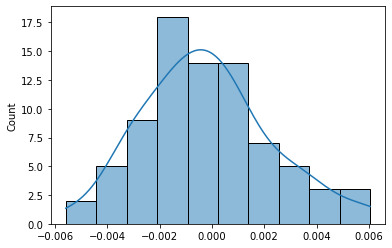

In [37]:
# Grafico de residuos
sns.histplot(vecm_res.resid[:,0], kde = True)

<AxesSubplot:xlabel='activar', ylabel='residuos'>

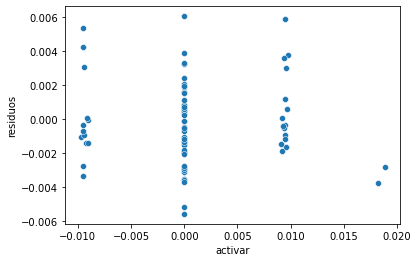

In [38]:
d = {'activar': data2.iloc[:80,0] ,'residuos': vecm_res.resid[:,0]}
residuos_1 = pd.DataFrame(d)
#data_mora.loc[:,'mora']
#print(len(vecm_res.resid[:,0]))
#print(data_mora.iloc[:82,0])
residuos_1.head()
sns.scatterplot(data =residuos_1, x="activar", y="residuos")

<AxesSubplot:xlabel='mes_ano', ylabel='residuos'>

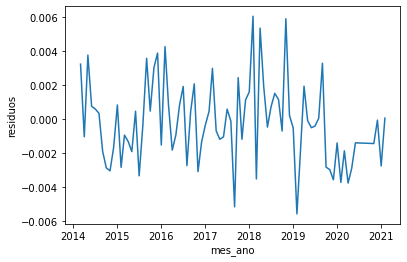

In [39]:
sns.lineplot(data =residuos_1, x=residuos_1.index, y="residuos")

In [120]:
# Impulso respuesta de VECM
#num_periods = 12
#ir = vecm_res.irf(periods=num_periods)
#ir.plot(plot_stderr=False)

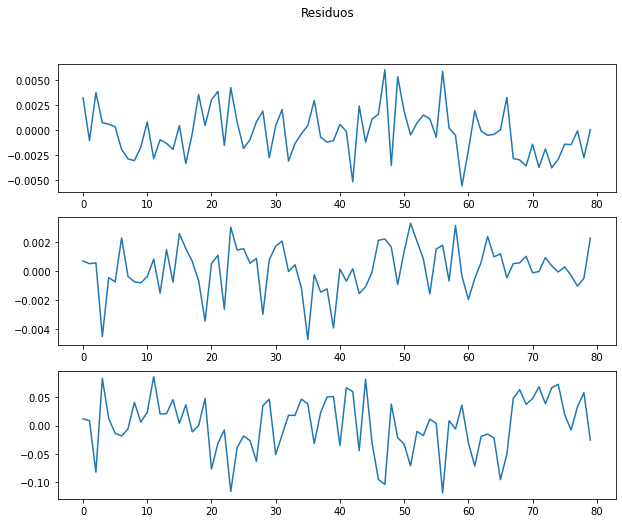

In [40]:
import matplotlib.pyplot as plt
fig,ax =  plt.subplots( 3, figsize = ( 10, 8))
fig.suptitle('Residuos')
ax[0].plot(vecm_res.resid[:,0])
ax[1].plot(vecm_res.resid[:,1])
ax[2].plot(vecm_res.resid[:,2])

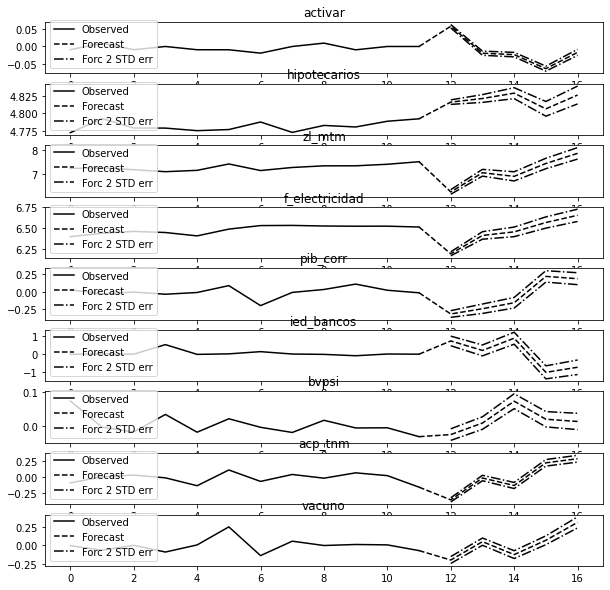

In [41]:
vecm_res.plot_forecast(steps=5, n_last_obs=12)

In [42]:
# Instantaneous causality
inst_caus_realgdp_r = vecm_res.test_inst_causality(causing="activar")
inst_caus_realgdp_r.summary()
#inst_caus_realgdp_r.conclusion

Test statistic,Critical value,p-value,df
47.81,15.51,0.000,8


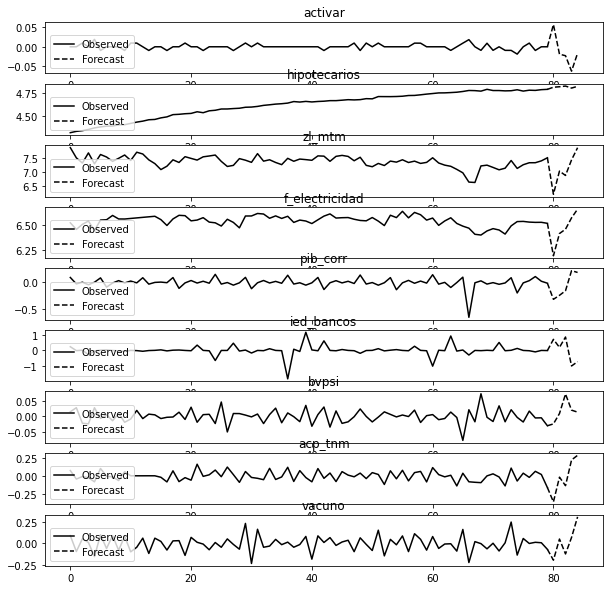

In [44]:
vecm_res.plot_forecast(steps=5, plot_conf_int=False)

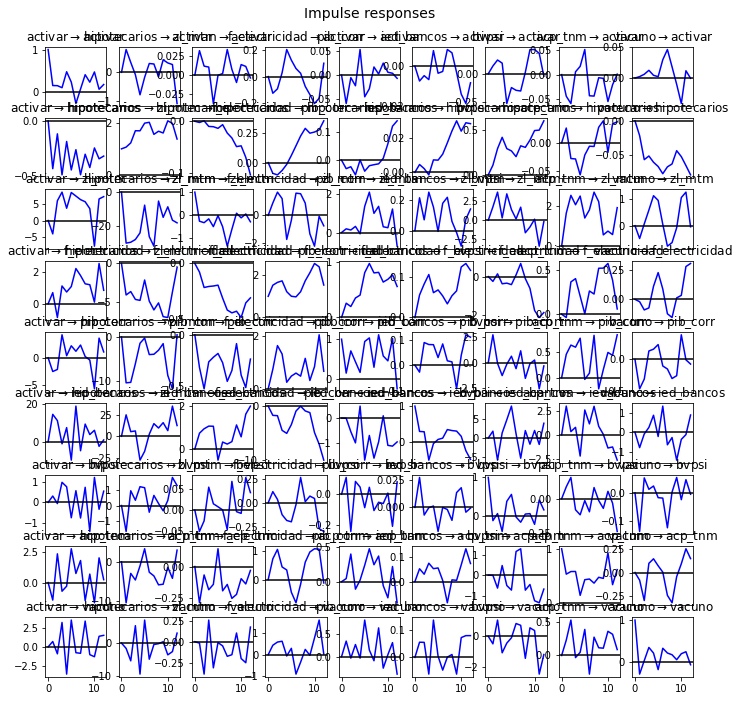

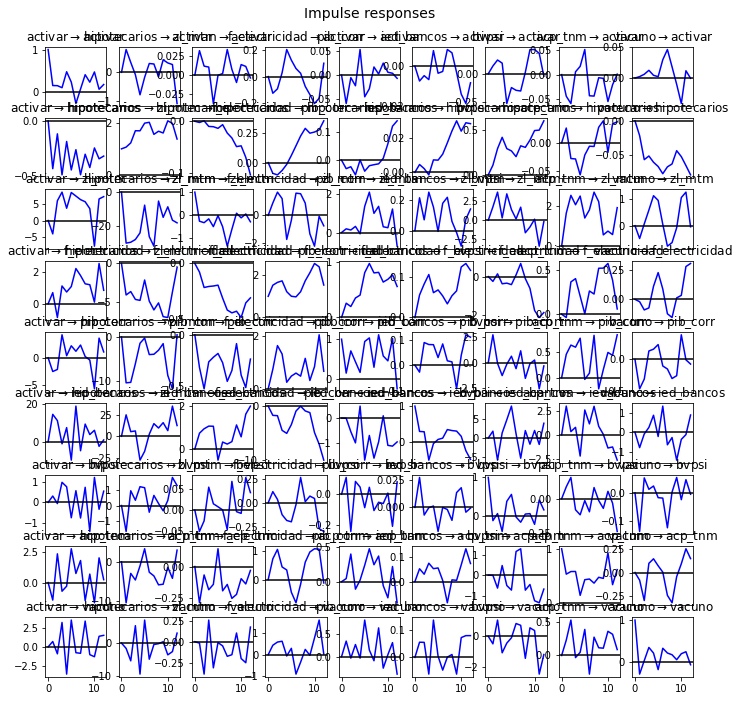

In [45]:
# Impulso respuesta de VECM
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

In [46]:
# Durbin Watson sobre las ecuaciones
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_res.resid)

for col, val in zip(data2.columns, out):
    print(col, ':', round(val, 2))

activar : 1.81
hipotecarios : 1.72
zl_mtm : 1.58
f_electricidad : 1.43
pib_corr : 1.68
ied_bancos : 1.4
bvpsi : 1.57
acp_tnm : 1.28
vacuno : 2.04
